# **Ephemeris vs SP3 Orbits**


In this notebook, we analyze exactly how far should the ephemeris be inteepolated to get the accurate satellite position in the orbit. In this experiment, the satellite position is interpolated from the brodcast ephemeris and compared with the interpolation from SP3 orbits.


Required Files:
- Broadcast Ephemeris (RINEX)
- SP3 Orbits (SP3)


In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path

navPath = Path("./data/HAL100USA_R_20220350000_01D_GN.rnx.gz")
sp3Path = Path('./data/igs21955.sp3.Z')

The rinex navigation file `HAL100USA_R_20220350000_01D_GN.rnx` is collected from HAL100USA IGS station which contains one day ephemeris data. The 
SP3 file `igs21995.sp3` is collected from IGS website which contains the satellite orbits for the same day with 15min sampling rate for all satellite.

Let's first parse the rinex navigation and sp3 files see the data.

In [2]:
from navigator.parse import Parser, IParseGPSNav, IParseSP3GPS

# Create a parser object for respective file types
navParser = Parser(iparser=IParseGPSNav())
sp3Parser = Parser(iparser=IParseSP3GPS())

In [3]:
_, navData = navParser(filepath=navPath)
_, sp3Data = sp3Parser(filepath=sp3Path)

Let's see the data for each file.

In [4]:
navData.head()

SVclockBias  SVclockDrift  SVclockDriftRate  IODE  \
time                sv                                                       
2022-02-03 23:59:44 G07     0.000308  3.069545e-12               0.0  21.0   
                    G13     0.000256  6.139089e-12               0.0   1.0   
                    G25     0.000280  5.456968e-12               0.0   6.0   
2022-02-04 00:00:00 G02    -0.000650 -7.958079e-13               0.0  39.0   
                    G05    -0.000070 -1.364242e-12               0.0  81.0   

                             Crs        DeltaN        M0           Cuc  \
time                sv                                                   
2022-02-03 23:59:44 G07  56.6875  5.036638e-09 -0.074410  3.099442e-06   
                    G13 -60.6250  3.982309e-09  2.280546 -3.077090e-06   
                    G25 -21.0625  5.168430e-09 -0.977646 -8.828938e-07   
2022-02-04 00:00:00 G02  96.7500  4.627336e-09  0.745779  4.880130e-06   
                    G05 -62.0625  4.879132e-09 -3.039409 -3.186986e-06   

                         Eccentricity       Cus  ...  GPSWeek  L2Pflag  SVacc  \
time                sv                           ...                            
2022-02-03 23:59:44 G07      0.015497  0.000008  ...   2195.0      0.0    2.0   
                    G13      0.005798  0.000013  ...   2195.0      0.0    2.0   
                    G25      0.010467  0.000005  ...   2195.0      0.0    2.0   
2022-02-04 00:00:00 G02      0.020672  0.000008  ...   2195.0      0.0    2.0   
                    G05      0.005867  0.000003  ...   2195.0      0.0    2.0   

                         health           TGD  IODC  TransTime  FitIntvl  \
time                sv                                                     
2022-02-03 23:59:44 G07     0.0 -1.117587e-08  21.0   424818.0       4.0   
                    G13     0.0 -1.117587e-08   1.0   424818.0       4.0   
                    G25     0.0  5.587935e-09   6.0   429738.0       4.0   
2022-02-04 00:00:00 G02     0.0 -1.769513e-08  39.0   430638.0       4.0   
                    G05     0.0 -1.117587e-08  81.0   424818.0       4.0   

                         spare0  spare1  
time                sv                   
2022-02-03 23:59:44 G07     NaN     NaN  
                    G13     NaN     NaN  
                    G25     NaN     NaN  
2022-02-04 00:00:00 G02     NaN     NaN  
                    G05     NaN     NaN  

[5 rows x 31 columns]

In [5]:
sp3Data.head()

ECEF                       x             y             z     clock  \
time       sv                                                        
2022-02-04 G01  1.385665e+07 -4.672040e+06  2.187383e+07  0.000440   
           G02 -1.434943e+07 -1.728744e+07 -1.340568e+07 -0.000650   
           G03  2.223951e+07 -1.163699e+07  8.418511e+06 -0.000106   
           G04  2.268494e+07 -1.564326e+06 -1.378947e+07 -0.000192   
           G05 -1.802182e+07 -1.959660e+06 -1.962300e+07 -0.000070   

ECEF                   dclock  
time       sv                  
2022-02-04 G01   0.000000e+00  
           G02  6.786668e-316  
           G03  6.786668e-316  
           G04  6.786668e-316  
           G05  6.786668e-316

The SP3 file contains the satellite position in ECEF coordinate starting from 00:00:00 to 23:45:00 with 15min sampling rate. 

In [6]:
minTime = sp3Data.index.get_level_values('time').min()
maxTime = sp3Data.index.get_level_values('time').max()

print(f'Min Time: {minTime}')
print(f'Max Time: {maxTime}')

Min Time: 2022-02-04 00:00:00
Max Time: 2022-02-04 23:45:00


Let's grab a ephemeris from a satellite from the navigation file.

In [7]:
g07 = navData.xs(key='G07', level='sv', drop_level=False).iloc[[2]]
g07

,,SVclockBias,SVclockDrift,SVclockDriftRate,IODE,Crs,DeltaN,M0,Cuc,Eccentricity,Cus,...,GPSWeek,L2Pflag,SVacc,health,TGD,IODC,TransTime,FitIntvl,spare0,spare1
time,sv,,,,,,,,,,,,,,,,,,,,,
2022-02-04 18:00:00,G07,0.000308,3.069545e-12,0.0,90.0,45.78125,4.841630e-09,3.096146,0.000002,0.015502,0.000009,...,2195.0,0.0,2.0,0.0,-1.117587e-08,90.0,489618.0,4.0,NaN,NaN


We grabbed the ephemeris for satellite G05 at 2022-02-04 18:00:00. Let's interpolate the ephemeris and see the satellite position for certain time in specific interval.

In [8]:
import pandas as pd

# Interpolation Frequency
interFreq = pd.Timedelta(minutes=10)

In [9]:
# Let's get TOC for G07
toc = g07.index.get_level_values('time')[0]
toc

Timestamp('2022-02-04 18:00:00')

We will interpolate the ephemeris from time TOC with `interFreq` sampling rate.

In [10]:
from navigator.core import Satellite, IGPSEphemeris, IGPSSp3

# Create a satellite object
ephemerisInterpolator = Satellite(iephemeris=IGPSEphemeris())
sp3Interpolator = IGPSSp3()

These two interpolator will interpolate the ephemeris for TOE to given time.

In [11]:
coordFromEphemeris = []

initial_time = toc
for _ in range(25):
    coordFromEphemeris.append(
        ephemerisInterpolator(
            t=initial_time, metadata=None, data=g07, no_clock_correction=True
        )[['x', 'y', 'z']]
    )
    initial_time += interFreq

coordFromEphemeris = pd.DataFrame(
    [coordFromEphemeris[i].values[0] for i in range(len(coordFromEphemeris))],
    columns=['x', 'y', 'z',],
)

coordFromEphemeris.head()

,x,y,z
0,-2.055746e+07,-7.409715e+06,1.581052e+07
1,-1.940757e+07,-7.767546e+06,1.704401e+07
2,-1.818693e+07,-8.187218e+06,1.815292e+07
3,-1.690766e+07,-8.672112e+06,1.912910e+07
4,-1.558237e+07,-9.224148e+06,1.996531e+07


As we can see, we have interpolated the ephemeris from TOC to 250 min + TOC with 10 min sampling rate. Let's sanity check the satellite position from the ephemeris. 

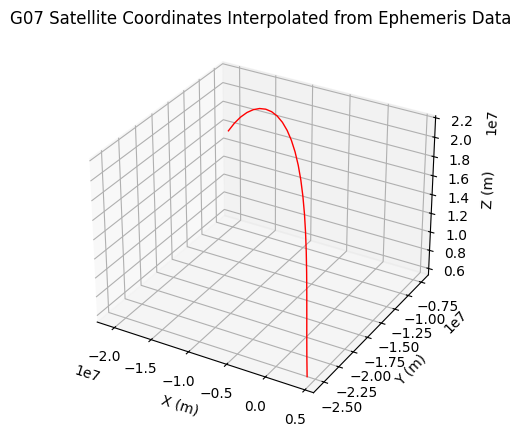

In [12]:
import matplotlib.pyplot as plt

# Plot the coordinates from ephemeris
fig = plt.figure(figsize=(10, 5))

# 3D plot
ax = fig.add_subplot(111, projection='3d')


ax.plot(
    coordFromEphemeris['x'],
    coordFromEphemeris['y'],
    coordFromEphemeris['z'],
    label='Ephemeris',
    color='red',
    linewidth=1,
)

ax.title.set_text(f'G07 Satellite Coordinates Interpolated from Ephemeris Data')
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)');

Let's interpolate the satellite position from SP3 file for the same peroiod of time and compare the results.

In [13]:
g07sp3 = sp3Data.xs(key='G07', level='sv')
coordFromSp3 = []
initial_time = toc
for _ in range(25):
    coordFromSp3.append(
        sp3Interpolator.compute(t=initial_time, metadata=None, data=g07sp3)
    )
    initial_time += interFreq

coordFromSp3 = pd.DataFrame(coordFromSp3)[['x', 'y', 'z']]
coordFromSp3.head()

,x,y,z
0,-2.055746e+07,-7.409716e+06,1.581052e+07
1,-1.940757e+07,-7.767546e+06,1.704402e+07
2,-1.818693e+07,-8.187219e+06,1.815292e+07
3,-1.690766e+07,-8.672113e+06,1.912910e+07
4,-1.558237e+07,-9.224149e+06,1.996531e+07


We have a coordinate of satellite position from ephemeris and SP3 file. Let's plot the trajectory of the satellite.

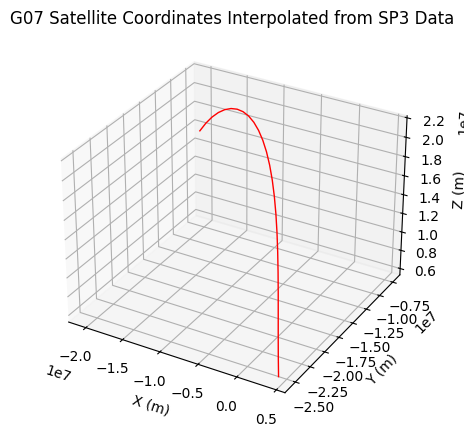

In [14]:
fig2 = plt.figure(figsize=(10, 5))

ax2 = fig2.add_subplot(111, projection='3d')

ax2.plot(
    coordFromSp3['x'],
    coordFromSp3['y'],
    coordFromSp3['z'],
    label='SP3',
    color='red',
    linewidth=1,
)

ax2.title.set_text(f'G07 Satellite Coordinates Interpolated from SP3 Data')

ax2.set_xlabel('X (m)')
ax2.set_ylabel('Y (m)')
ax2.set_zlabel('Z (m)');

Let's see the difference between the coordinates interoplated from ephemeris and SP3 file.

In [15]:
import numpy as np

# Calculate the difference between the two coordinates
dDiff = (coordFromEphemeris - coordFromSp3).apply(np.linalg.norm, axis=1)

dDiff.index *= (interFreq.total_seconds() / 60)

Let's plot the difference between the coordinates interoplated from ephemeris and SP3 file.

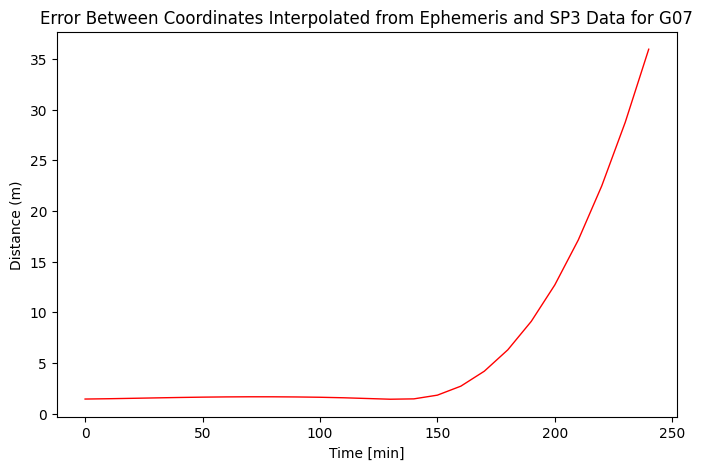

In [16]:
fig3 = plt.figure(figsize=(8, 5))

ax = fig3.add_subplot(111)

ax.plot(dDiff, label='Difference', color='red', linewidth=1)

ax.title.set_text(
    f'Error Between Coordinates Interpolated from Ephemeris and SP3 Data for G07'
)

ax.set_xlabel('Time [min]')
ax.set_ylabel('Distance (m)');

# Save the plot
fig3.savefig('ephemeris_sp3_error.png')

Clearly, the difference between interpolated coordinates from ephemeris increase exponentially as the time goes on. Since the interFreq is 10min and the exponential increase happens at 15.

In [17]:
# The exponential growth is at 15 from the plot
print(f"The error eucledian distance explods at {15 * 10} min")

The error eucledian distance explods at 150 min


The critial time after which the ephemeris is not accurate after 150 min from TOC.

Let's perform the same experiment for all satellites and see the critical time for each satellite. The function `compute_error` with compute the difference between the coordinates interoplated from ephemeris and SP3 file for given satellite.

In [18]:
def compute_error(interFreq, navData, sp3Data, sv):
    """
    Compute the error between the coordinates obtained from ephemeris and SP3 data for a given satellite.

    Parameters:
    - initial_time (datetime): The initial time for computing the coordinates.
    - interFreq (int): The time interval between each coordinate computation.
    - navData (pd.DataFrame): The navigation data containing satellite ephemeris.
    - sp3Data (pd.DataFrame): The SP3 data containing satellite coordinates.
    - sv (str): The satellite identifier.

    Returns:
    - dDiff (pd.Series): The error between the coordinates obtained from ephemeris and SP3 data.
    """
    g07 = navData.xs(key=sv, level='sv', drop_level=False).iloc[[2]]
    toc = g07.index.get_level_values('time')[0]

    ephemerisInterpolator = Satellite(iephemeris=IGPSEphemeris())
    sp3Interpolator = IGPSSp3()

    coordFromEphemeris = []
    initial_time = toc
    for _ in range(25):
        coordFromEphemeris.append(
            ephemerisInterpolator(
                t=initial_time, metadata=None, data=g07, no_clock_offset=True
            )[['x', 'y', 'z']]
        )
        initial_time += interFreq

    coordFromEphemeris = pd.DataFrame(
        [coordFromEphemeris[i].values[0] for i in range(len(coordFromEphemeris))],
        columns=['x', 'y', 'z'],
    )

    g07sp3 = sp3Data.xs(key=sv, level='sv')
    coordFromSp3 = []
    initial_time = toc
    for _ in range(25):
        coordFromSp3.append(
            sp3Interpolator.compute(t=initial_time, metadata=None, data=g07sp3)
        )
        initial_time += interFreq

    coordFromSp3 = pd.DataFrame(coordFromSp3)[['x', 'y', 'z']]

    dDiff = (coordFromEphemeris - coordFromSp3).apply(np.linalg.norm, axis=1)

    # Change the x-ticks to minutes scale
    dDiff.index = dDiff.index * (interFreq.total_seconds() / 60)

    return dDiff

Now, let's plot the critical time for each satellite.

In [19]:
# Plot the error for all satellites
all_sv = navData.index.get_level_values('sv').unique()

data = {}

interFreq = pd.Timedelta(minutes=10)
for sv in all_sv:
    try:
        data[sv] = compute_error(interFreq, navData, sp3Data, sv)
    except Exception as e:
        
        raise e

Seem like there is out of bound error for two satellites (G13 and G14), since their ephemeris + 150 min is out of SP3 stamp time.

In [20]:
data = pd.DataFrame(data)
data.head()

,G07,G13,G25,G02,G05,G06,G11,G12,G14,G15,...,G10,G26,G16,G27,G01,G03,G08,G21,G04,G09
0.0,1.433497,1.451279,1.586031,0.818147,1.029135,2.205605,1.479566,1.137345,1.210527,1.302156,...,2.868180,1.571931,1.716736,1.562873,2.002849,2.624529,1.605041,1.831566,0.991046,3.354952
10.0,1.464717,1.403346,1.605216,0.779179,0.997679,2.203303,1.515815,1.167191,1.211402,1.262453,...,2.852567,1.591374,1.718201,1.577178,1.964584,2.661903,1.567633,1.815480,0.988152,3.309562
20.0,1.504556,1.362984,1.618823,0.784637,0.982696,2.162264,1.528239,1.196627,1.210552,1.323821,...,2.818838,1.610934,1.704178,1.590394,1.927899,2.742359,1.528901,1.696549,1.015952,3.184734
30.0,1.546846,1.344639,1.624004,0.835767,0.984561,2.092337,1.513209,1.223686,1.209036,1.484181,...,2.761903,1.629376,1.677698,1.607996,1.897378,2.861871,1.514737,1.517584,1.084063,3.000282
40.0,1.587247,1.355183,1.618870,0.925976,1.000569,2.007385,1.473251,1.246041,1.208994,1.714754,...,2.681759,1.644960,1.646566,1.636961,1.876381,3.011901,1.550170,1.372845,1.188658,2.787649


We have all the data to plot the critical time for each satellite.

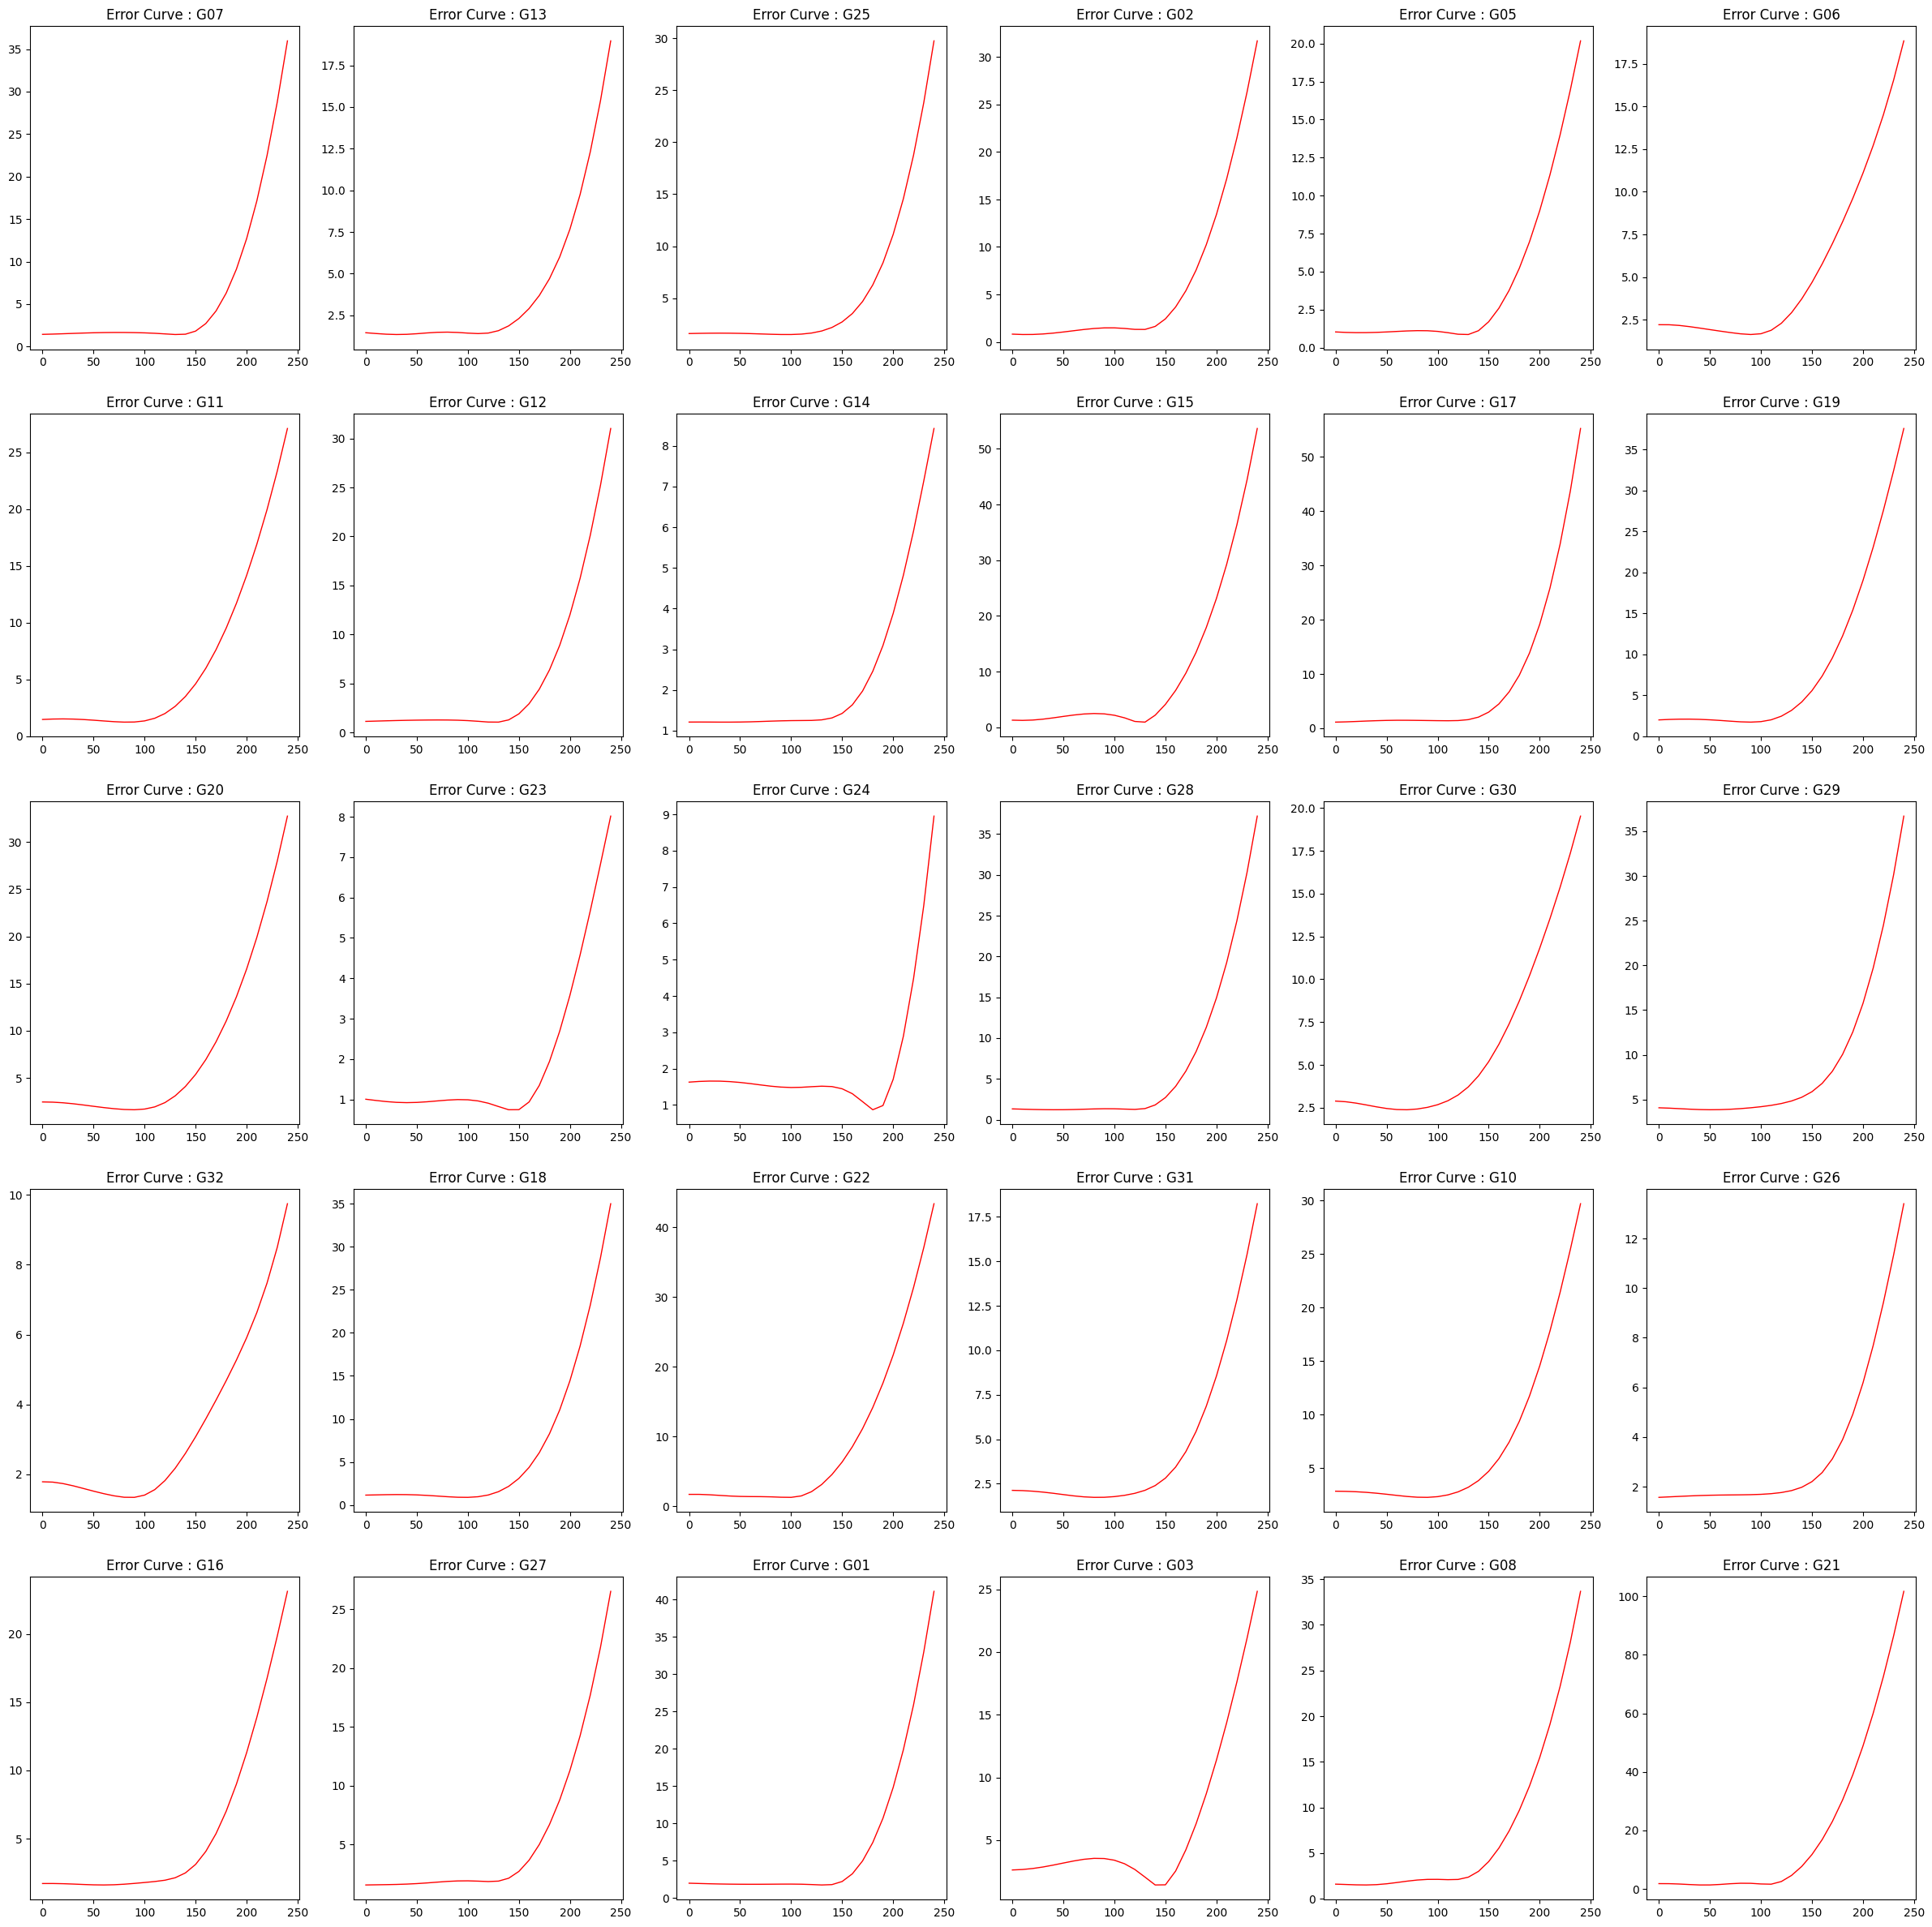

In [21]:
fig, ax = plt.subplots(5, 6, figsize=(30, 30))

for i in range(5):
    for j in range(6):
        ax[i, j].plot(
            data[data.columns[i * 6 + j]], label='Difference', color='red', linewidth=1
        )
        ax[i, j].set_title(f'Error Curve : {data.columns[i*6+j]}')

It seems like the critical time for each satellite is around 150 min from TOC which substantiates the previous experiment.